<p>This is a data simulation that is meant to show several things: <br>
<ul>
<li>How to simule a bernoulli random event</li>
<li>How to build a Logistic Regression using Sci-kit learn</li>
<li>Visualize a linear separating hyperplane </li>
<li>Use the prior 3 steps to better understand overfitting.</li>
</ul>
</p>

<p>First we import necessary libraries and set up functions that can generate a random bernoulli dataset.<br> 
We input the parameters of the linear hyperplane and get a dataset with $X=<x_1, x_2>$ and $Y \in [0,1]$</p>

In [3]:

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

def getP(val):
    '''
    Get f(x) where f is the logistic function...returns a probability
    '''
    return (1 + math.exp(-1*val))**-1

def getY(val):
    '''
    Return a binary indicator based on a binomial draw with prob = f(val), f being the logistic function.
    '''
    return (int(getP(val) > np.random.uniform(0, 1, 1)[0]))

def gen_logistic_dataframe(n, alpha, betas):
    '''
    A function that generates a random logistic dataset.
    n is the number of samples
    Alpha, betas are the logistic truth, where alpha is the intercept and betas coefficients for vectors.
    Uses the shape of betas to determine number of features generated.
    '''
    X = np.random.random([n, len(betas)])
    Y = map(getY, X.dot(betas) + alpha)
    d = pd.DataFrame(X, columns= ['f'+ str(j) for j in range(X.shape[1])])
    d['Y'] = Y
    return d


Now for this example we'll generate some data. We let the truth actually be random. We do it this way so we can surprise ourselves with what our models actually learn. 

We'll also plot it. When we look at the plot, try and guess where the separating line should be?

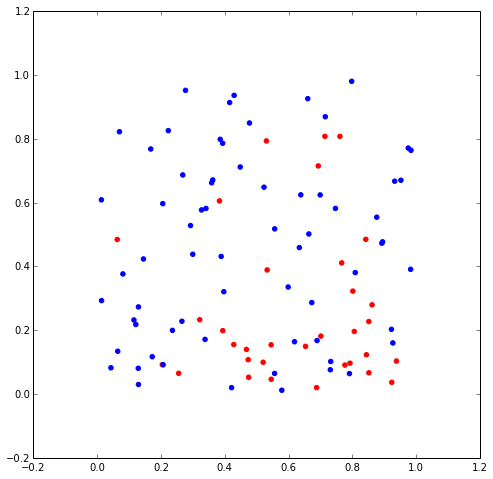

In [9]:
%matplotlib inline

n = 100
alpha = np.random.randint(-2,2)
beta = np.array([np.random.randn()*2, np.random.randn()*2])
data = gen_logistic_dataframe(n, alpha, beta)

plt.figure(figsize = (8, 8))
plt.scatter(data['f0'][(data['Y']==0)].values,data['f1'][(data['Y']==0)].values,color='r')
plt.scatter(data['f0'][(data['Y']==1)].values,data['f1'][(data['Y']==1)].values,color='b')
plt.show()

<p>Generally when we have features X and a target variable Y, our goal is to understand understand how Y varies with X.

We can start by just plotting Y as a function of X. Since Y is binary we bin the X features and measure $E[Y|X_{bin}]$.
</p>

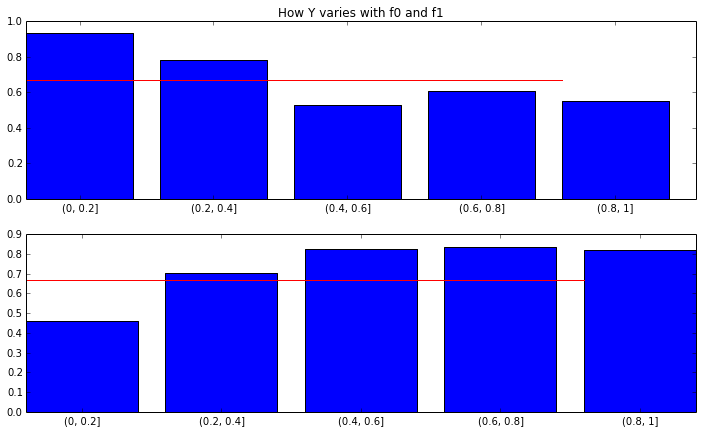

In [18]:
'''
We have 2 features and a target variable Y. Before we do any modeling, we can group the features
and explore the relationship with Y visually
'''
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(12, 7))
#Explore the effect of f0 and f1 by grouping and doing various tests
cuts = np.arange(-20, 20, 2)/10.0
data['f0_grp'] = pd.cut(data.f0.values, cuts)
data['f1_grp'] = pd.cut(data.f1.values, cuts)
d0 = data.groupby('f0_grp').mean()
d1 = data.groupby('f1_grp').mean()

#Now plot it
k = len(d0['Y'])
k_rng = np.arange(k)
p = data['Y'].mean()

xrng = np.arange(len(d0['Y']))

ax1 = plt.subplot(211)
plt.title('How Y varies with f0 and f1')
ax1.bar(xrng, d0['Y'])
ax1.plot(k_rng, p*np.ones(k), 'r-')
ax1.set_xticks(0.4 + xrng)
ax1.set_xticklabels(d1.index.values, rotation=0)


ax2 = plt.subplot(212)
ax2.bar(k_rng, d1['Y'])
ax2.set_xticks(0.4 + xrng)
ax2.set_xticklabels(d1.index.values, rotation=0)
ax2.plot(k_rng, p*np.ones(k), 'r-')

plt.show()

Another way to test the relationship between the features and the target is to use a logistic regression. This is our first look at
linear models/logistic regression in this class. In short, we want to fit a line $\alpha+\beta X$ such that:

$P(Y|X)=f(X)$ where $f(X)=(1+e^{-(\alpha+\beta X)})^{-1}$

In the next section we fit the model and then we plot it.

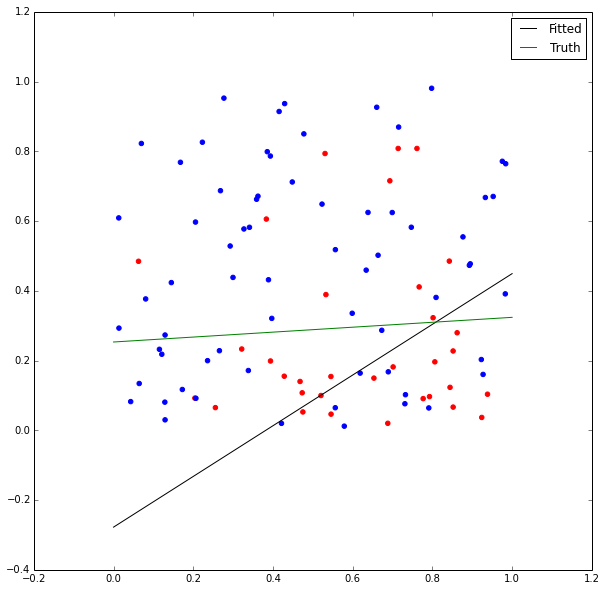

In [23]:
logreg = linear_model.LogisticRegression(C=1e30)
logreg.fit(data[['f0','f1']],data['Y'])

def plot_dec_line(mn, mx, b0, b1, a, col, lab):
    '''
    This function plots the results of a bivariate logistic regression as a separating hyper-plane
    '''
    x = np.linspace(mn, mx, 100)
    dec_line = map(lambda x_i: -1*(x_i*b0/b1 + a/b1), x)
    plt.plot(x, dec_line, col, label = lab)
    

    
#Now we'll plot the data, the fitted curve and the actual line
plt.figure(figsize = (10, 10))
plot_dec_line(0, 1, logreg.coef_[0][0], logreg.coef_[0][1], logreg.intercept_[0], 'black', 'Fitted')
plot_dec_line(0, 1, beta[0], beta[1], alpha, 'green', 'Truth') 
plt.scatter(data['f0'][(data['Y']==0)].values, data['f1'][(data['Y']==0)].values, color='r')
plt.scatter(data['f0'][(data['Y']==1)].values, data['f1'][(data['Y']==1)].values, color='b')
plt.legend()
plt.show()

<p>The nice thing about simulations is we know the truth and we can compare our learned model to the truth.  This is incredibly useful 

way to study the phenomenon of overfitting. In the above example we can compare the truth (that we created of course) to best answer

given by the data.  Sometimes the fitted vs. truth lines don't match exactly. In extreme cases they are no where near each other.

Let's see how the number of records affects this phenomenon.

</p>

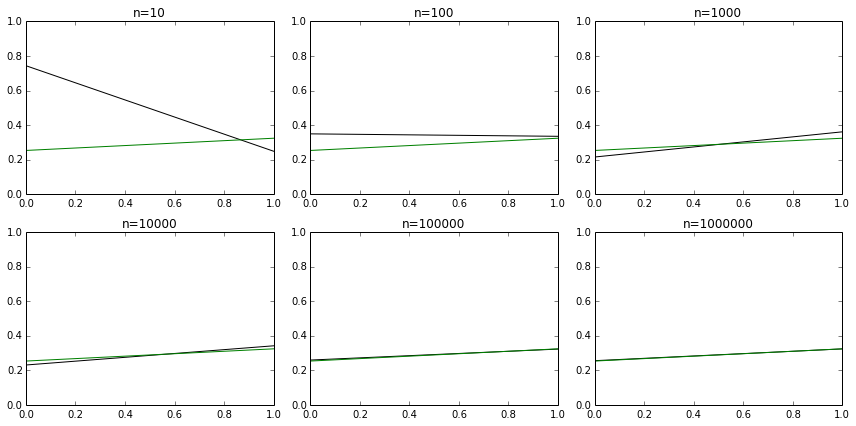

In [33]:
def get_a_fit(alpha, beta, n):
    '''
    Generate a dataset and return a fitted model to it
    '''    
    dat_n = gen_logistic_dataframe(n, alpha, beta)
    lr = linear_model.LogisticRegression(C=1e30)
    return lr.fit(dat_n[['f0','f1']], dat_n['Y'])

#Now get a few models with different sample sizes
ms = [ get_a_fit(alpha, beta, 10**k) for k in range(1,7) ]

#Now let's plot these against each other 
fig = plt.figure(figsize = (12, 6))
for k in range(6):
    ax = fig.add_subplot(2,3,k+1)
    plt.title("n={}".format(10**(k+1)))
    plot_dec_line(0, 1, ms[k].coef_[0][0], ms[k].coef_[0][1], ms[k].intercept_[0], 'black', 'na')
    plot_dec_line(0, 1, beta[0], beta[1], alpha, 'g', 'na')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

fig.tight_layout()
    
plt.show()

<p>Look at how much the black (fitted) line varies from the green (truth) line as we vary the size of the sample. With n=10, the fitted separating plane is nearly perpendicular to the truth. We only visibly fit the truth exactly when n=1 MM (though we come very close with a few orders of magnitude lower).  The lesson here is that with more data our fitted curve is expected to look more like the actual truth. Each realization of the green curve is a single estimate from one subset of some theoretically infinite data set. The fitted curve is essentially a function of the data. If we expect randomness across datasets (an artifact of sampling), we also should expect randomness in the curves we fit. The plot below illustrates this.</p>


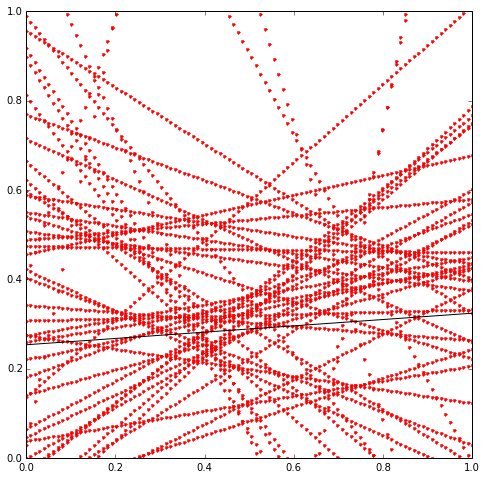

In [51]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(111)
for k in range(50):
    try:
        '''
        I found that with small datasets of size=10, sometimes you generate a dataset with only 1 class.
        This helps us get around that problem when it happens.
        '''
        mod = get_a_fit(alpha, beta, 10)     
        plot_dec_line(0, 1, mod.coef_[0][0], mod.coef_[0][1], mod.intercept_[0], 'r.', 't')
    except:
        continue
        
plot_dec_line(0, 1, beta[0], beta[1], alpha, 'k', 't')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.show()

<p>The black line here shows the truth. Each red line is a line fitted against a single realization of the data. Most are close to the

truth, and it looks like E[red line]=black line. In real world situtations though we only get one data set. When your data is small

(and model too complex), you might get unlucky and it up with a line that is very different from the theoretical truth. The red lines

that are far off from the black lines are examples of unlucky overfitting. In real applications we'll likely never know the true 

underlying data distribution, but with the techniques taught in this course, we can at least be confident that overfitting can be 

avoided.</p>
